# Projet phylog√©n√©tique
Th√©ophile Sanchez (theophile.sanchez@inria.fr) - Sarah Cohen Boulakia

------

## Introduction

Au cours de ce projet, vous √©tudierez trois esp√®ces disparues de f√©lins qui vivaient autrefois sur le continent Am√©ricain. Ces trois esp√®ces, le _smilodon_ (tigre √† dents de sabre), l'*homotherium* (*scimitar toothed tigers*) et *Miracinonyx trumani* (gu√©pard am√©ricain) se sont √©teintes il y a environ 13 000 ans, √† la fin de la derni√®re p√©riode glaciaire. Des s√©quences ADN anciennes de la prot√©ine cytochrome b de ces esp√®ces ont pu √™tre s√©quenc√©es et vont vous permettre de retrouver les liens de parent√©s entre ces esp√®ces et des esp√®ces de f√©lins contemporaines : le chat domestique, le lion, le l√©opard, le tigre, le puma, le gu√©pard et les chats sauvages africains, chinois et europ√©ens. Sont aussi pr√©sentes dans le jeu de donn√©e des s√©quences issues d'esp√®ces ext√©rieures aux f√©lins.

Afin de reconstruire l'arbre phylog√©n√©tique de ces esp√®ces, vous utiliserez une m√©thode bas√©e sur le calcul des distances √©volutives entre les s√©quences ADN des prot√©ines. Notez qu'une d√©marche similaire peut-√™tre appliqu√©e aux s√©quences d'acides amin√©s.

Les diff√©rentes √©tapes qui vous permetterons de construire l'arbre sont d√©taill√©es dans ce notebook. Vous devrez impl√©menter les algorithmes en Python et r√©pondre aux questions dans les cellules pr√©vues.

Quelques conseils :
- Utiliser au maximum les fonctions pr√©sentes dans les packages de python (sauf si il vous est explicitement demand√© de les r√©impl√©menter). Si un probl√®me vous para√Æt courant, il existe surement d√©j√† une fonction pour le r√©soudre. Pour ce projet vous serez limit√© aux packages de base, √† Numpy et ETE (seulement pour l'affichage des arbres).
- Si une partie de votre code ne vous semble pas tr√®s explicite, ajoutez des commentaires pour l'expliquer. Une personne qui lit votre code doit pouvoir comprendre son fonctionnement facilement.
- N'h√©sitez pas √† chercher dans la documentation et sur internet. Cependant, faites tr√®s attention au plagiat, d'apr√®s les r√®gles de l'universit√© vous risquez beaucoup s'il est av√©r√© ! 

Le projet est √† rendre **en bin√¥me** par mail. Vous regrouperez votre notebook et les fichiers n√©cessaires √† son fonctionnement dans une archive portant vos noms et pr√©noms.

------
## Importation des s√©quences

Le format FASTA permet de stocker plusieurs s√©quences (ADN, ARN ou peptidiques) dans un fichier. Les s√©quences que vous allez √©tudier ont √©t√© regroup√©es dans le fichier `cat_dna.fasta`.

**Exercice 1 :** √âcriver une fonction permettant d'importer un fichier au format fasta et de le stocker dans un dictionnaire. Les cl√©s seront les noms des s√©quences et les valeurs du dictionnaire seront les s√©quences d'adn.

In [1]:
import re

def parse_fasta(file):
    # Patterns matching
    PNAME = "\s*>\s*([\w\W]*[\w\S]+){1}\s*"
    PSEQ = "\s*([ATGC-]+){1}\s*"
    PARENTHESIS = re.compile("[()]")
    res = {}
    name = ""
    with open(file, "r") as fo:
        fasta_lines = fo.readlines()
        for line in fasta_lines:
            match = re.search(PNAME, line)
            # Nom de l'esp√®ce
            if match != None:
                # On enl√®ve les parenth√®ses car elles ne sont
                # pas admises pour le format newick
                name = PARENTHESIS.sub("", match.group(1))
                res[name] = ""
            # S√©quence ADN
            else:
                match = re.search(PSEQ, line)
                if match != None and name != "":
                    res[name] += match.group(1)
        return res

In [2]:
fasta = parse_fasta("cat_dna.fasta")
print(fasta)

{'Sabertooth DNA Smilodon': 'CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGCTCCTTATTAGGAGTGTGCTTAATCTTACAAATCCTCACTGGCTTATTTCTAGCCATACATTATACACCAGATACAACAACCGCCTTCTCATCAGTTACCCACATTTGCCGTGATGAATTACGGCTGAATTATCCGATATATACGCCAATGGAGCTTCCATATTCTTCATCTGCCTATATATACATGTAGGTCGAGCATATACTAC', 'Homotherium DNA': 'CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCTCCAACATCTCAGCATGATGAAACTTCGGATCCCTACTAGGCATTTGCCTAATTCTTCAAATCCTCACAGGCTTATTCCTAGCCATACACTACACATCAGACACAACAACTGCTTCTCATCAATCGCCCATATTTGCCGTGACGTAAATTATGGTTGAATTATCCGATATATACACGCCAATGGAGCCTCTATATTCTTCCTGTCTATACCTACATGTAGCTCGAGAATTTATTAC', 'American Cat DNA Miracinonyx': 'CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGTTCCCTATAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTCTTCCTGGCTATACAACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATCTGTCGTGACGTCAATTACGGCTGAATTATTCGGTATTACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCACGTAGGGCGAGGAATATATTAC', 'Spotted Hyena DNA': 'CTCATTAAAATTATCAACAAATCATTCATTGACCTCCCCACCCCA

------
## Alignement des s√©quences

La m√©thode que vous utiliserez pour calculer l'arbre phylog√©n√©tique n√©cessite de calculer la distance √©volutive entre les s√©quences. Avant de pouvoir les calculer, il faut d'abord aligner les s√©quences en consid√©rant trois types de mutations :
- les substitutions (un nucl√©otide est remplac√© par un autre)
- les insertions
- les d√©l√©tions
Par exemple, les s√©quences "ACTCCTGA" et "ATCTCGTGA" ont plusieurs alignements possibles : 

$A_1$ :
```
-ACTCCTGA
ATCTCGTGA
```

$A_2$ :
```
A-CTCCTGA
ATCTCGTGA
```

$A_3$ :
```
AC-TCCTGA
ATCTCGTGA
```
.

.

.

Il est aussi possible qu'une d√©l√©tion ne soit pas une mutation, mais en r√©alit√© d√ª √† un mauvais s√©quen√ßage ou √† la d√©gradation ADN comme c'est souvent le cas pour le s√©quen√ßage d'ADN d'esp√®ces disparues. 

Le "-" d√©signe un *gap*, c'est √† dire un "trou" dans l'alignement qui a √©t√© caus√© par une insertion ou une d√©letion. On regroupe ces deux types de mutations sous le terme indel.

Ces alignements correspondent √† une multitude d'histoires phylog√©n√©tiques diff√©rentes. Pour s√©lectionner le meilleur alignement il faut donc introduire l'hypoth√®se du maximum de parcimonie qui privil√©gie l'histoire phylog√©n√©tique qui implique le moins d'hypoth√®ses et donc, le moins de changements √©volutifs. Par exemple, parmis les trois alignements ci-dessus on preferera l'alignement 2 car il correspond au sc√©nario avec le moins de mutations:
- l'alignement 1 implique au minimum 1 indel et 2 substitutions
- l'alignement 2 implique au minimum 1 indel et 1 substitutions
- l'alignement 3 implique au minimum 1 indel et 2 substitutions

On peut maintenant d√©finir un score d'identit√© que l'on va augmenter de 1 lorsque qu'il n'y pas eu de mutation et ainsi obtenir la matrice suivante :

|   &nbsp;   | A | C | G | T | - |
|   -   | - | - | - | - | - |
| **A** | 1 | 0 | 0 | 0 | 0 |
| **C** | 0 | 1 | 0 | 0 | 0 |
| **G** | 0 | 0 | 1 | 0 | 0 |
| **T** | 0 | 0 | 0 | 1 | 0 |
| **-** | 0 | 0 | 0 | 0 | 0 |

Cette matrice correspond au mod√®le d'√©volution de l'ADN d√©fini par Jukes et Cantor qui fait l'hypoth√®se d'un taux de mutation √©quivalent pour chacun des nucl√©otides. Cependant, en r√©alit√© ces taux ne sont pas les m√™mes partout, on sait par exemple que le taux de transition (substitution A$\leftrightarrow$G ou C$\leftrightarrow$T) est diff√©rent du taux de transversions (substitution A$\leftrightarrow$T, C$\leftrightarrow$G, C$\leftrightarrow$A ou G$\leftrightarrow$T) et que d'autres facteurs devrait √™tre pris en compte comme la fr√©quence du nucl√©otide dans l'ADN. [C'est pour cette raison qu'il existe beaucoup de mod√®les diff√©rents d'√©crivant l'√©volution de l'ADN.](https://en.wikipedia.org/wiki/Models_of_DNA_evolution) Dans la suite de ce projet nous utiliserons la matrice de similarit√© $S$ suivante : 

|   &nbsp;   | A  | C  | G  | T  | -  |
|   -   | -  | -  | -  | -  | -  |
| **A** | 10 | -1 | -3 | -4 | -5 |
| **C** | -1 | 7  | -5 | -3 | -5 |
| **G** | -3 | -5 | 9  | 0  | -5 |
| **T** | -4 | -3 | 0  | 8  | -5 |
| **-** | -5 | -5 | -5 | -5 | 0  |

**Exercice 2 :** √âcriver la fonction permettant de calculer le score entre deux alignements avec la matrice de similarit√© pr√©c√©dente puis afficher le score des trois alignements $A_1$, $A_2$ et $A_3$. La classe permettant d'importer une matrice et de calculer le score entre deux lettres vous est d√©j√† fournie, la matrice de similarit√© est stock√©e dans le fichier `dna_matrix` :


In [3]:
import numpy as np


class SimilarityMatrix:
    def __init__(self, filename):
        with open(filename) as f:
            self.letters = f.readline().split()
            self.values = np.loadtxt(filename, skiprows=1, usecols=range(1, len(self.letters) + 1))
        
    def score(self, letter1, letter2): # return the similarity score between letter1 and letter2
        return self.values[self.letters.index(letter1)][self.letters.index(letter2)]
    
# Example
similarity_matrix = SimilarityMatrix('dna_matrix')
print('Score between G and C:', similarity_matrix.score('G', 'C'))
print('Score between A and a gap:', similarity_matrix.score('-', 'A'))

Score between G and C: -5.0
Score between A and a gap: -5.0


In [4]:
def compute_score(A, B):
    N = len(A)
    M = len(B)
    res = 0
    if N == M:
        for i in range(0, N):
            res += similarity_matrix.score(A[i], B[i])
        return res
    else:
        raise ValueError(f"len(al1) = {N} != len(al2) = {M}")

In [5]:
A1 = ("-ACTCCTGA", "ATCTCGTGA")
A2 = ("A-CTCCTGA", "ATCTCGTGA")
A3 = ("AC-TCCTGA", "ATCTCGTGA")
assert(compute_score(A1[0], A1[1]) == -5-4+7+8+7-5+8+9+10)
assert(compute_score(A2[0], A2[1]) == 10-5+7+8+7-5+8+9+10)
assert(compute_score(A3[0], A3[1]) == 10-3-5+8+7-5+8+9+10)

------
### Algorithme de Needleman-Wunsch

Maintenant que vous avez vu ce qu'est une matrice de similarit√© et comment calculer le score de similarit√© d'un alignement, vous allez devoir impl√©menter un algorithme permettant de trouver le meilleur alignement global entre deux s√©quences. Avec deux s√©quences √† aligner de taille $n$ et $m$, la premi√®re √©tape consiste √† initialiser deux matrices de taille $(n+1) \times (m+1)$. La premi√®re est la matrice de score $M$ et la seconde sera la matrice de *traceback* $T$. 

Par exemple, avec la matrice $S$ et les s√©quences $A =$ "ACTCCTGA" et $B =$ "ATCTCGTGA", on initialise $M$ comme si l'on ajoutait des *gaps* partout :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | 0 |-5 |-10|-15|-20|-25|-30|-35|-40|-45|
| **A** |-5 | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-10| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-15| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-20| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** |-25| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** |-30| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** |-45| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** |-40| &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||

Puis on initialise $T$ :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **G** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | u | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; ||


Il faut ensuite remplir la matrice $M$ en suivant la formule $M_{ij} = \max(M_{i-1j-1} + s(A_i, B_j), M_{ij-1} + s(A_i, gap), M_{i-1j} + s(B_j,gap) )$ avec $i \in {2, \dots, n+1}$, $j \in {2, \dots, m+1}$ et la fonction $s$ qui calcule le score de similarit√© entre deux nucl√©otides. Pour chaque case de $T$ on remplie par :
- 'd' (*diagonal*) si $M_{ij}$ a √©t√© calcul√© en utilisant la diagonale $M_{i-1j-1}$,
- 'l' (*left*) si $M_{ij}$ a √©t√© calcul√© en utilisant la case de gauche $M_{ij-1}$,
- 'u' (*up*) si $M_{ij}$ a √©t√© calcul√© en utilisant la case du haut $M_{i-1j}$.

On obtient alors les matrices suivantes $M$ et $T$ : 

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** |  0| -5|-10|-15|-20|-25|-30|-35|-40|-45|
| **A** | -5| 10|  5|  0| -5|-10|-15|-20|-25|-30|
| **C** |-10|  5|  7| 12|  7|  2| -3| -8|-13|-18|
| **T** |-15|  0| 13|  8| 20| 15| 10|  5|  0| -5|
| **C** |-20| -5|  8| 20| 15| 27| 22| 17| 12|  7|
| **C** |-25|-10|  3| 15| 17| 22| 22| 19| 14| 11|
| **T** |-30|-15| -2| 10| 23| 18| 22| 30| 25| 20|
| **G** |-35|-20| -7|  5| 18| 18| 27| 25| 39| 34|
| **A** |-40|-25|-12|  0| 13| 17| 22| 23| 34| 49|

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | l | l | l | l | l | l | l | l | l |
| **A** | u | d | l | l | l | l | l | l | l | d |
| **C** | u | u | d | d | l | d | l | l | l | l |
| **T** | u | u | d | l | d | l | l | d | l | l |
| **C** | u | u | u | d | l | d | l | l | l | l |
| **C** | u | u | u | d | d | d | d | d | l | d |
| **T** | u | u | d | u | d | l | d | d | l | l |
| **G** | u | u | u | u | u | d | d | u | d | l |
| **A** | u | d | u | u | u | d | u | d | u | d |

Il suffit maintenant de regarder le dernier √©l√©ment $M_{nm} = 49$ pour avoir le score de l'alignement. Pour avoir l'alignement lui-m√™me, il faut partir de $T_{nm}$ et remonter la "trace" jusqu'√† arriver au 'o'. Un 'd' correspond √† un *match* entre les deux s√©quences, 'l' √† un *gap* dans la s√©quence $A$ et 'u' √† un *gap* dans la s√©quence $B$. En revenant √† l'exemple pr√©c√©dent on obtient la trace suivante :

|   &nbsp;   | - | A | T | C | T | C | G | T | G | A |
|   -   | - | - | - | - | - | - | - | - | - | - |
| **-** | o | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **A** | &nbsp; | d | l | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **C** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; | &nbsp; |
| **T** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; | &nbsp; |
| **G** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d | &nbsp; |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | &nbsp; | d |

Elle correspond √† l'alignement :
```
A-CTCCTGA
ATCTCGTGA
```

**Exercice 3 :** Impl√©menter l'algorithme de Needlman et Wunsch. Il prendra en param√®tre deux s√©quences et une matrice de similarit√© et retournera leur alignement. Tester le avec les s√©quences "ACTCCTGA" et "ATCTCGTGA".

In [6]:
class NeedlmanWunsh:
    
    def __init__(self, A, B, score_matrix="dna_matrix"):
        '''
        @param A, B: s√©quences str
        @param score_matrix: nom fichier de matrice de score
        '''
        
        self.A = A
        self.B = B
        self.s = SimilarityMatrix(score_matrix)
        self.n = len(self.A)
        self.m = len(self.B)
        
        # Initialisation matrice de score
        self.M = np.zeros((self.n + 1, self.m + 1), dtype=int)
        # Boucles car score pas forc√©ment constant
        for i in range(1, self.n + 1):
            self.M[i][0] = self.s.score(self.A[i - 1], '-') + self.M[i - 1][0]
        for j in range(1, self.m + 1):
            self.M[0][j] = self.s.score(self.B[j - 1], '-') + self.M[0][j - 1]
        
        # Initialisation matrice de Traceback
        self.T = np.zeros((self.n + 1, self.m + 1), dtype=str)
        self.T[0][0] = 'o'
        self.T[1:self.n + 1][:,0] = 'u'
        self.T[0][1:self.m + 1] = 'l'

    # Fonction r√©cursive terminale pour remonter
    # le chemin de la matrice Traceback
    def __traceback(self, n, m, res):
        # ATTENTION: n, m sont des arguments pas des attributs
        current = self.T[n][m]
        if current == 'o':
            return res
        else:
            if current == 'd':
                res = (self.A[n - 1] + res[0], self.B[m - 1] + res[1])
                return self.__traceback(n - 1, m - 1, res)
            elif current == 'l':
                res = ('-' + res[0], self.B[m - 1] + res[1])
                return self.__traceback(n, m - 1, res)
            elif current == 'u':
                res = (self.A[n - 1] + res[0], '-' + res[1])
                return self.__traceback(n - 1, m, res)
            else:
                raise ValueError(f"current = {current} impossible value")

    def best_alignment(self):
        '''
        @return: meileur alignement (A', B')
        '''
        
        # Remplissage des matrices M et T
        for i in range(1, self.n + 1):
            for j in range(1, self.m + 1):
                # max(ùëÄùëñ‚àí1ùëó‚àí1+ùë†(ùê¥ùëñ,ùêµùëó),ùëÄùëñùëó‚àí1+ùë†(ùê¥ùëñ,ùëîùëéùëù),ùëÄùëñ‚àí1ùëó+ùë†(ùêµùëó,ùëîùëéùëù))
                d = ('d', self.M[i - 1][j - 1] + self.s.score(self.A[i - 1], self.B[j - 1]))
                l = ('l', self.M[i][j - 1] + self.s.score(self.A[i - 1], '-'))
                u = ('u', self.M[i - 1][j] + self.s.score(self.B[j - 1], '-'))
                # Maximum selon le score dans [(lettre, score),...]
                res = max([d, l, u], key=lambda x: x[1])
                self.M[i][j] = res[1]
                self.T[i][j] = res[0]
            
        # Traceback
        return self.__traceback(self.n, self.m, ("", ""))

In [7]:
nw = NeedlmanWunsh("ACTCCTGA", "ATCTCGTGA")
best = nw.best_alignment()
assert (best == ("A-CTCCTGA", "ATCTCGTGA"))
print(best)

('A-CTCCTGA', 'ATCTCGTGA')


**Exercice 4 :** Appliquer votre algorithme aux donn√©es. Vous remarquerez que Needlman et Wunsch permet d'aligner deux s√©quences entre elles, or vous devez aligner toute les s√©quences en m√™me temps. Adapter l'algorithme en faisant au plus simple, seulement les s√©quences d'ADN anciens ont une longueur diff√©rente des autres.

In [8]:
# Exercice annul√© par Th√©ophile Sanchez pour cause d'impossibilit√© de r√©alisation...

----
## Matrice de distance

Dans le cas de s√©quences tr√®s proches, on estime que la distance √©volutive r√©elle entre les s√©quences est proche de la p-distance qui est simplement le nombre de substitution dans l'alignement sur le nombre total de nucl√©otide. Pour simplifier, **on ignore les positions align√©es √† des gaps**. On applique ensuite la correction de Jukes-Cantor afin de prendre en compte le ph√©nom√®ne de saturation (un m√™me site peut muter plusieurs fois au cours du temps). Sa formule est $-(\frac{3}{4})\ln(1-(\frac{4}{3})\times \textit{p-distance})$.

**Exercice 5 :** Impl√©menter la fonction retournant la matrice de distance √† partir d'un dictionnaire de s√©quences. 

In [9]:
def pdistance(A, B):
    '''
    @param A, B: S√©quences str avec len(A) = len(B)
    @return: (nombre de substitutions int, nombre de nucl√©otides int)
    '''
    repl = 0
    nucl = 0
    NA = len(A)
    NB = len(B)
    if NA != NB: 
        raise ValueError(f"len(A)={NA} != len(B)={NB}")
    for (a, b) in zip(A, B):
        # On ignore les gaps
        if a != '-' and b != '-':
            # Substitution
            if a != b:
                repl += 1
                nucl += 1
            # Match
            else:
                nucl += 1
    return float(repl)/float(nucl)

def compute_distances(fasta, align=False):
    '''
    @param fasta: Dictionnaire nom <-> seq
    @param align: Aligner les s√©quences si tailles diff√©rentes
    @return: matrice des distances entre s√©quences
    '''
    n = len(fasta)
    if n < 2:
        raise ValueError(f"len(fasta) = {n} < 2 not enough")
    lk = list(fasta.keys())
    # Matrice identit√©
    M = np.eye(n, dtype=float)
    M[0][0] = 0.
    i = 1 
    j = 0
    # Remplissage du triangle inf√©rieur
    while i < n:
        # Quand diagonale on revient √† la ligne
        if M[i][j] == 1.:
            M[i][j] = 0.
            i += 1
            j = 0
        else:
            # Affichage de l'avancement
            print(f"M[{i}][{j}]=Dist({lk[i]}, {lk[j]})")
            # Calcul √©ventuel de l'alignement
            (A, B) = (fasta[lk[i]], fasta[lk[j]])
            if align:
                nw = NeedlmanWunsh(fasta[lk[i]], fasta[lk[j]])
                (A, B) = nw.best_alignment()
            # Calcul du nombre de substitutions
            M[i][j] = pdistance(A, B)
            j += 1
            
    # Correction de Jukes-Cantor
    return abs(-(3 / 4) * np.log(1 - (4 / 3) * M))

def triu_inf(M):
    '''
    @param M: Matrice triangulaire avec triangle bas et le reste √† 0.
    @return: M√™me matrice mais le triangle haut √† inf
    '''
    return M + np.triu(np.full(M.shape, np.inf))

import seaborn as sns
import matplotlib.pyplot as plt

def print_matrix(M, fasta):
    N = len(fasta)
    plt.figure(figsize=(N, N))
    sns.heatmap(M, annot=True, xticklabels=fasta, yticklabels=fasta)

In [10]:
M1 = compute_distances(fasta, align=True)

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

La p-distance est exprim√©e entre [0;1]. Plus elle est proche de 0, plus les s√©quences sont ressemblantes. Plus elle est proche de 1 plus les s√©quences sont diff√©rentes. La matrice-triangle affich√©e donne les p-distances de chacune des s√©quences du fichier fasta par comparaison deux √† deux.

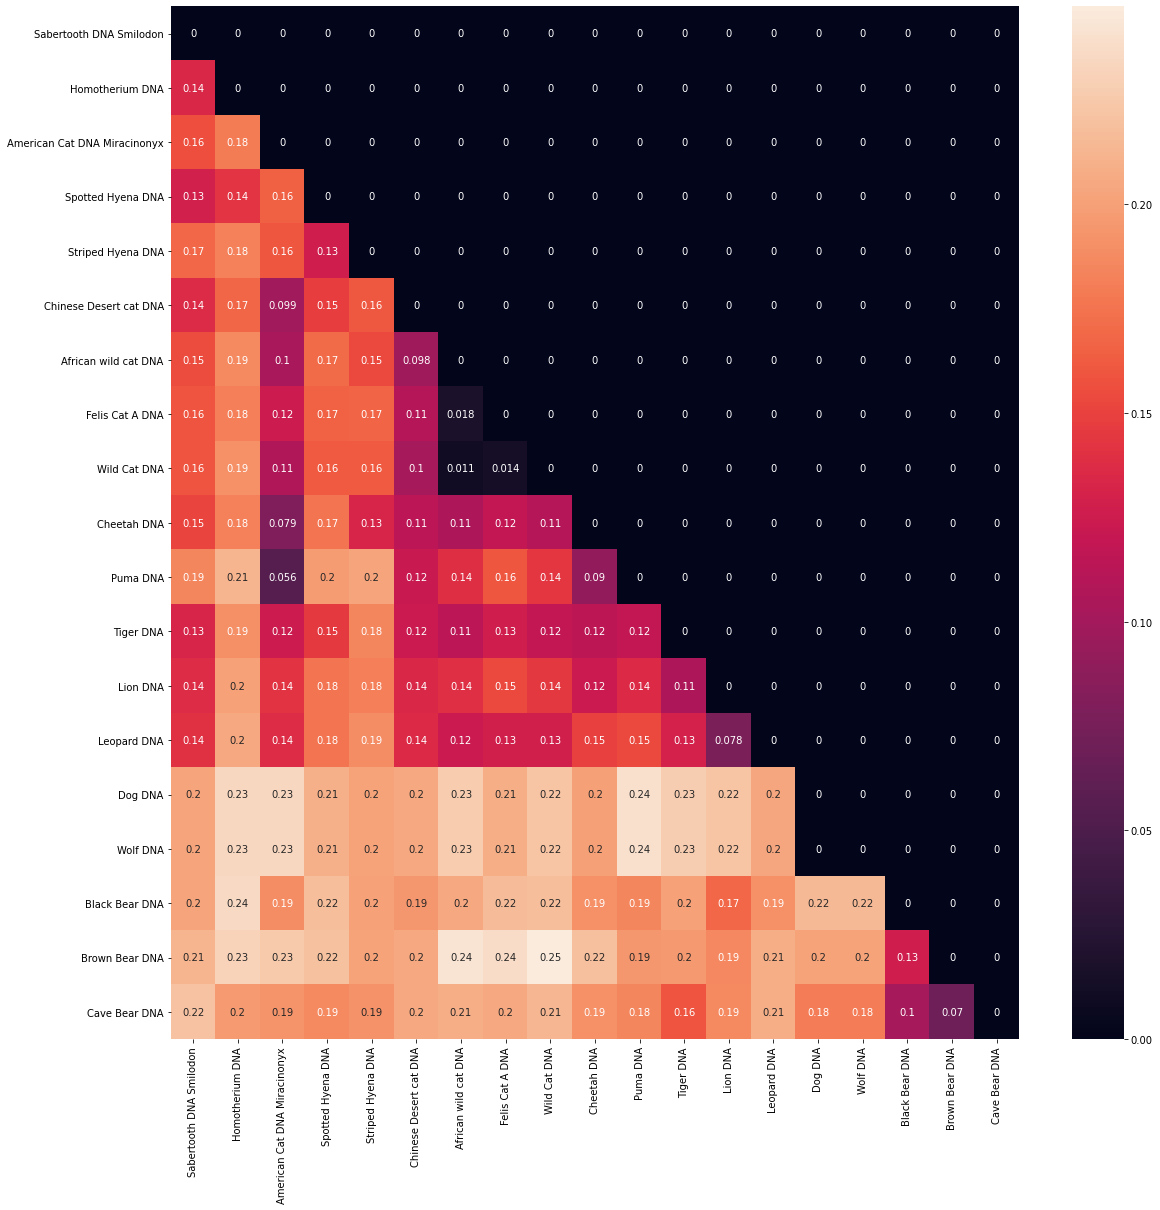

In [11]:
print_matrix(M1, fasta)

In [12]:
fasta_align = parse_fasta("msa_cat_dna.fasta")
print(fasta_align)

{'Sabertooth DNA Smilodon': 'CTAATTAAAATTATCAACCACTCATTCATTGATTTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGCTCCTTATTAGGAGTGTGCTTAATCTTACAAATCCTCACTGGCTTATTTCTAGCCATACATTATACACCAGATACAACAACCGCCTTCTCATCAGTTACCCACATTTGCCGTGATGA--ATTACGGCTGAATTATCCGAT--ATATACGCCAATGGAGCTTCCATATTCTTCATCTGCCTATATATACATGTAGGTCGAGCATATACTAC', 'Homotherium DNA': 'CTAATTAAAATCATCAACCAATCATTCATTGACTTACCTACCCCCTCCAACATCTCAGCATGATGAAACTTCGGATCCCTACTAGGCATTTGCCTAATTCTTCAAATCCTCACAGGCTTATTCCTAGCCATACACTACACATCAGACACAACAACTGC-TTCTCATCAATCGCCCATATTTGCCGTGACGTAAATTATGGTTGAATTATCCGATATATACACGCCAATGGAGCCTCTATATTCTTCCTGTCTATACCT--ACATGTAGCTCGAGAATTTATTAC', 'American Cat DNA Miracinonyx': 'CTTATTAAAATCATTAATCACTCATTCATTGATCTACCCACCCCATCCAACATTTCAGCATGATGAAACTTCGGTTCCCTA-TAGGGGTCTGCCTAATCCTACAAATCCTAACCGGCCTCTTCCTGGCTATA--CAACACATCAGACACAATAACCGCCTTTTCATCAGTTACTCACATCTGTCGTGACGTCAATTACGGCTGAATTATTCGGTAT-TACACGCCAACGGAGCCTCCATATTCTTTATCTGCCTATACATGCACGTAGGGCGAGAATATATTAC', 'Spotted Hyena DNA': 'CTCATTAAAATTATCAACAAATCATTCATTGACCT

In [13]:
M2 = compute_distances(fasta_align, align=False)

M[1][0]=Dist(Homotherium DNA, Sabertooth DNA Smilodon)
M[2][0]=Dist(American Cat DNA Miracinonyx, Sabertooth DNA Smilodon)
M[2][1]=Dist(American Cat DNA Miracinonyx, Homotherium DNA)
M[3][0]=Dist(Spotted Hyena DNA, Sabertooth DNA Smilodon)
M[3][1]=Dist(Spotted Hyena DNA, Homotherium DNA)
M[3][2]=Dist(Spotted Hyena DNA, American Cat DNA Miracinonyx)
M[4][0]=Dist(Striped Hyena DNA, Sabertooth DNA Smilodon)
M[4][1]=Dist(Striped Hyena DNA, Homotherium DNA)
M[4][2]=Dist(Striped Hyena DNA, American Cat DNA Miracinonyx)
M[4][3]=Dist(Striped Hyena DNA, Spotted Hyena DNA)
M[5][0]=Dist(Chinese Desert cat DNA, Sabertooth DNA Smilodon)
M[5][1]=Dist(Chinese Desert cat DNA, Homotherium DNA)
M[5][2]=Dist(Chinese Desert cat DNA, American Cat DNA Miracinonyx)
M[5][3]=Dist(Chinese Desert cat DNA, Spotted Hyena DNA)
M[5][4]=Dist(Chinese Desert cat DNA, Striped Hyena DNA)
M[6][0]=Dist(African wild cat DNA, Sabertooth DNA Smilodon)
M[6][1]=Dist(African wild cat DNA, Homotherium DNA)
M[6][2]=Dist(African wi

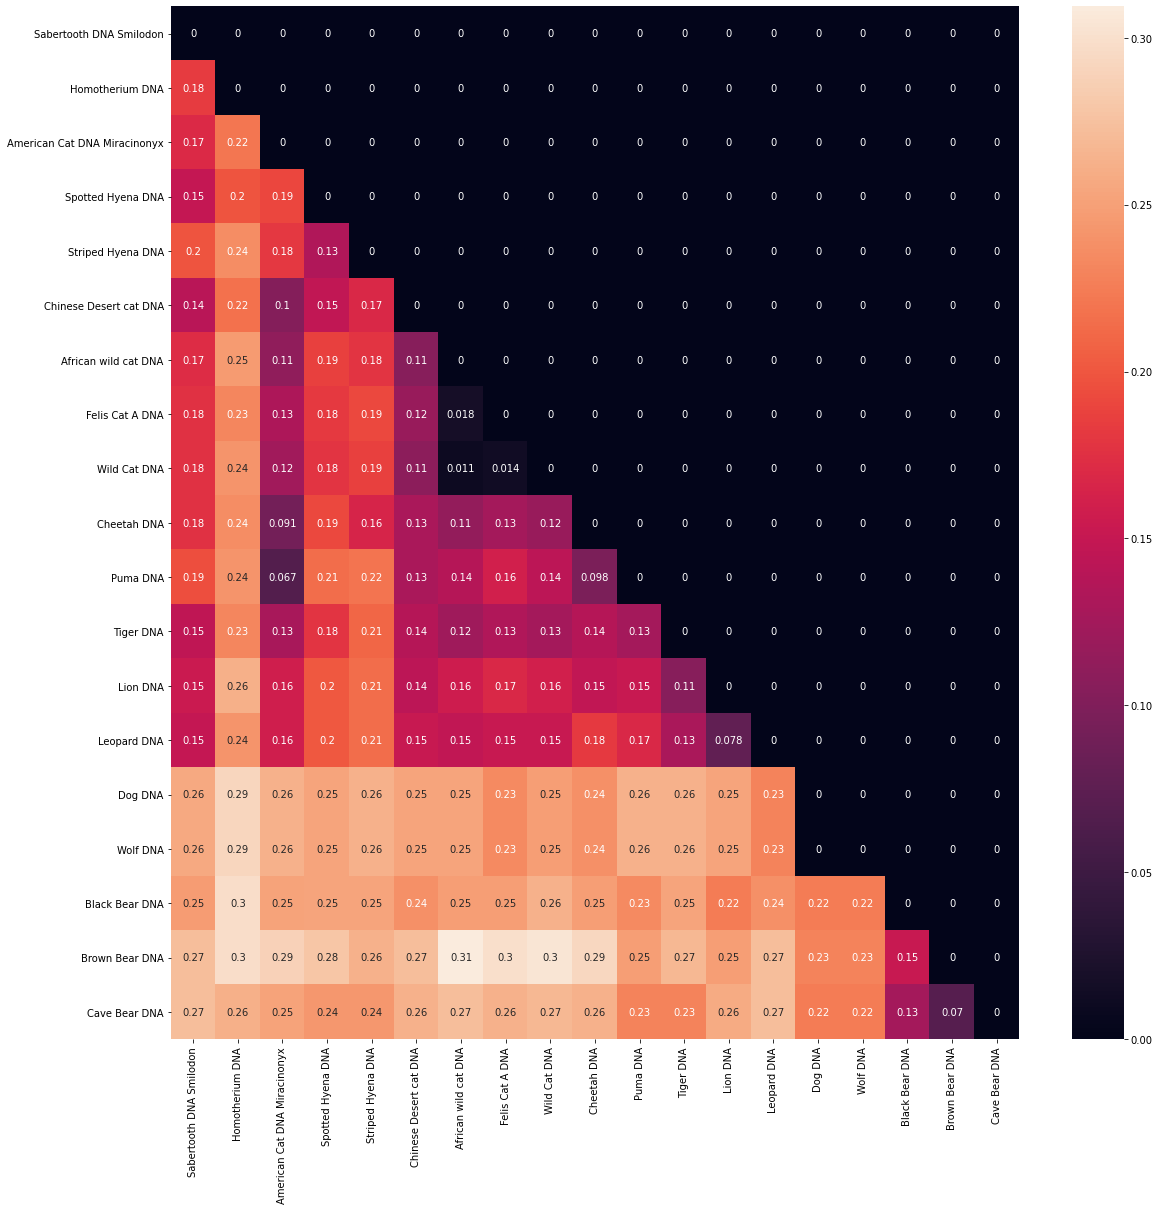

In [14]:
print_matrix(M2, fasta_align)

In [15]:
assert (fasta['Dog DNA'] == fasta['Wolf DNA'])
assert (fasta_align['Dog DNA'] == fasta_align['Wolf DNA'])

On remarque que 2 des s√©quences sont strictement identiques !

------
## Construction d'un arbre avec UPGMA

Gr√¢ce aux mesures de distances entre les s√©quences, on peut maintenant de construire l'arbre phylog√©n√©tique de la prot√©ine cytochrome b. Vous allez devoir pour cela impl√©menter l'algorithme UPGMA (*unweighted pair group method with arithmetic mean*) qui, malgr√© son nom compliqu√©, est l'une des m√©thodes les plus simples pour la construction d'arbre.

### Le format Newick

Le format Newick est l'un des formats utilis√© en phylog√©nie pour repr√©senter un arbre sous la forme d'une chaine de caract√®re. Le principe est simple, les groupes ayant la m√™me racine sont √©crit entre parenth√®ses et s√©par√©s par des virgules. Un groupe peut √™tre soit une feuille de l'arbre (dans notre cas une s√©quence), soit un autre groupe. La longueur de la branche de chaque groupe est √©crite apr√®s un double point et l'arbre est termin√© par un point virgule. Pour afficher l'arbre on peut utiliser les fonction du package ETE : 

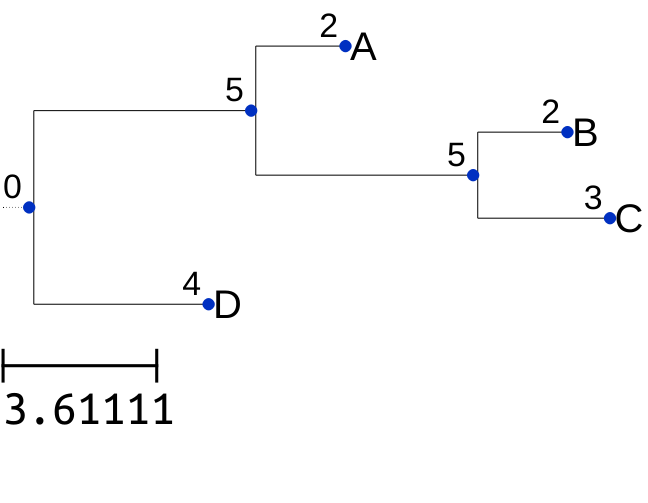

In [16]:
from ete3 import Tree, TreeStyle

newick_tree = '((A:2,(B:2,C:3):5):5,D:4);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 6 :** Re√©criver l'arbre suivant au format Newick puis afficher-le. Les nombres correspondent aux longueurs des branches :
![](tree.png)

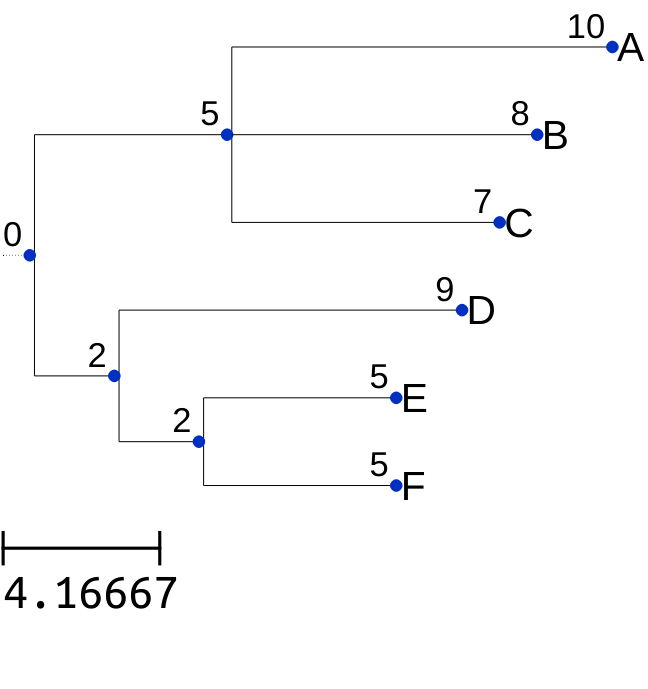

In [17]:
newick_tree = '((A:10, B:8, C:7):5, (D:9, (E:5, F:5):2):2);'
t = Tree(newick_tree)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

**Exercice 7 :** Expliquer la relation de parent√© entre $A$, $B$ et $C$ ? Qu'elles sont les hypoth√®ses qui pourraient expliquer ce type d'embranchement dans un arbre ? Donner une r√©ponse d√©taill√©e.

R√©ponse : Les esp√®ces A, B et C sont toutes apparent√©es au m√™me anc√™tre commun. En principe ce n'est pas possible, car un anc√™tre commun peut se diviser en seulement 2 sous-esp√®ces habituellement, du fait d'un √©v√®nement √† un instant t. Il est en effet, tr√®s rare qu'un m√™me env√®nement conduise √† une telle sp√©ciation ternaire. Mais, il est √©galement possible qu'on cache un anc√™tre commun entre B et C qui sont les 2 esp√®ces les plus similaires en terme de distance, et que la sp√©ciation soit due √† 2 √©v√®nements distincts. On peut aussi imaginer un cas rare de sp√©ciation ternaire. J'ai en t√™te par exemple une sp√©ciation g√©ographique. Une m√™me esp√®ce se retrouve r√©partie sur 3 √Æles diff√©rentes du fait d'une temp√™te donc en un seul √©v√®nement, puis chaque √Æle donne naissance √† une nouvelle esp√®ce. On aurait ainsi un embranchement ternaire.

### UPGMA

L'algorithme UPGMA se base sur la matrice de distance entre les s√©quences. √Ä chaque it√©ration, les s√©quences avec la distance la plus faible sont regroup√©es puis une nouvelle matrice de distance est calcul√©e avec le nouveau groupe. Cette √©tape est r√©p√©t√©e jusqu'√† n'avoir plus qu'un seul groupe. Par exemple, avec la matrice de distance entre les s√©quences $A$, $B$, $C$ et $D$ suivante :

|   &nbsp;   | A | B | C | D |
|   -   | - | - | - | - |
| **A** | &nbsp; | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |
| **D** | 2 | 4 | 8 | &nbsp; |

Les s√©quences $A$ et $D$ sont les plus proches ($distance(A,D)=2$). On les regroupe et on met √† jour la matrice :

|   &nbsp;   | (A, D) | B | C |
|   -   | - | - | - |
| **(A, D)** | &nbsp; | &nbsp; | &nbsp; |
| **B** | 4 | &nbsp; | &nbsp; |
| **C** | 8 | 8 | &nbsp; | &nbsp; |

On regroupe maintenant $(A,D)$ et $B$ ($distance((A,D),B) = 4$) :

|   &nbsp;   | ((A, D), B) | C |
|   -   | - | - |
| **((A, D), B)** | &nbsp; | &nbsp; |
| **C** | 8 | &nbsp; |

Important : les nouvelles distances sont calcul√©es en moyennant les distances entre les membres du nouveau groupe et des groupes non modifi√©s pond√©r√© par le nombre d'UTOs dans chaque groupe. Avec $i$ et $j$ les deux membres du groupe nouvellement form√© et k les groupes restant : $d_{ij,k} = \frac{n_id_{ik}}{n_i + n_j}+ \frac{n_jd_{jk}}{n_i + n_j}$. Par exemple avec la distance entre $((A, D), B)$ et $C$:

$distance(((A, D), B), C) = (distance((A, D), C)*2 + distance(B, C)) \mathbin{/} 3 = (8*2 + 8) \mathbin{/} 3 = 8 $.

L'arbre final √©crit dans le format Newick est : $((A, D), B), C);$ 

Et avec les distances : $((A:1, D:1):1, B:2):2, C:4);$ 

**Exercice 8 :** Impl√©menter une version d'UPGMA qui calcule l'arbre au format Newick **avec les distances** puis appliquer votre algorithme aux donn√©es. 

In [18]:
def upgma(M, lname):
    '''
    @param M: Matrice des distances dont triangle sup√©rieur √† 0.
    @param lname: Liste des noms de s√©quences
    @return: Arbre phylo format Newick str
    '''
    
    # Fonction d'acc√®s √† la case (i,j)
    # de la matrice M triangle bas m√™me
    # si les indices ne sont pas donn√©s
    # dans le bon ordre
    def get_tril(i, j):
        if i > j:
            return M[i][j]
        else:
            return M[j][i]
    
    # Initalisation
    N = M.shape[0]
    # Pr√©-condition √† respecter
    if N != len(lname) or N < 2:
        raise ValueError(f"N={N} != len(lname)={len(lname)} or N < 2")
        
    # N√©cessaire car sinon min √† 0. sur triangle sup√©rieur
    # Remplace les 0. du triangle sup par inf
    M = triu_inf(M)
    
    # Distance jusqu'aux feuilles depuis anc√™tre commun
    # On suppose qu'elle est identique pour n'importe quelle branche
    dleaf = [0 for _ in range(N)] 
    
    # Poids des groupes externes pour obtenir les ni, nj
    uto = [1 for _ in range(N)]
    
    # Tant que la matrice est suffisamment grande
    while N > 2: # Condition d'arr√™t N = 2
        
        # Recherche des indices de la distance minimale
        (mini, minj) = np.unravel_index(np.argmin(M), (N, N))
        assert (mini > minj) # Invariant matrice triangle
        
        # Fonction de correction d'indice
        def correct(index):
            if index >= mini:
                return index + 1
            else:
                return index
        
        # Calcul de la distance entre les 2 esp√®ces
        d = M[mini][minj] / 2.
        d1 = d - dleaf[mini]
        d2 = d - dleaf[minj]
        # Fusion des noms dans lname[minj] et suppression lname[mini]
        lname[minj] = f"({lname[minj]}:{d2},{lname[mini]}:{d1})"
        lname.pop(mini)
        
        # Correction de dleaf[minj] et suppression de dleaf[mini]
        dleaf[minj] = M[mini][minj] / 2.
        dleaf.pop(mini)
        
        # Assignation des poids
        ni = uto[mini]
        nj = uto[minj]
        # Correction de uto[minj] et suppression de uto[mini]
        uto[minj] += uto[mini]
        uto.pop(mini)
        
        # Cr√©ation et remplissage de la nouvelle matrice
        N -= 1
        P = np.full((N, N), np.inf)
        for i in range(N):
            for j in range(N):
                # Triangle inf√©rieur
                if i > j:
                    # Ligne case fusionn√©e
                    if minj == i:
                        jj = correct(j)
                        P[i][j] = ((ni * get_tril(mini, jj)) + (nj * get_tril(minj, jj))) / (ni + nj)
                    # Colonne case fusionn√©e
                    elif minj == j:
                        ii = correct(i)
                        P[i][j] = ((ni * get_tril(mini, ii)) + (nj * get_tril(minj, ii))) / (ni + nj)
                    else:
                        ii = correct(i)
                        jj = correct(j)
                        P[i][j] = M[ii][jj]
        M = P
        
    # N = 2
    d = M[1][0] / 2.
    d1 = d - dleaf[1]
    d2 = d - dleaf[0]
    return f"({lname[0]}:{d2},{lname[1]}:{d1});"

In [19]:
M = np.array(
    [[0., 0., 0., 0.],
     [4., 0., 0., 0.],
     [8., 8., 0., 0.],
     [2., 4., 8., 0.]])
upgma(M, ["A", "B", "C", "D"])

'(((A:1.0,D:1.0):1.0,B:2.0):2.0,C:4.0);'

In [20]:
M = np.array(
    [[0., 0., 0., 0.],
     [4., 0., 0., 0.],
     [8., 2., 0., 0.],
     [4., 4., 8., 0.]])
upgma(M, ["A", "B", "C", "D"])

'((A:2.0,D:2.0):1.0,(B:1.0,C:1.0):2.0);'

((((Sabertooth DNA Smilodon:0.0675532932453834,Homotherium DNA:0.0675532932453834):0.010321577100173493,(Spotted Hyena DNA:0.06336875464189762,Striped Hyena DNA:0.06336875464189762):0.01450611570365927):0.006892312916636792,((((American Cat DNA Miracinonyx:0.02789389504568546,Puma DNA:0.02789389504568546):0.01443475517950871,Cheetah DNA:0.04232865022519417):0.0180207105110171,(Chinese Desert cat DNA:0.051705876671468004,((African wild cat DNA:0.0053192381219836545,Wild Cat DNA:0.0053192381219836545):0.0026892618316515897,Felis Cat A DNA:0.008008499953635244):0.04369737671783276):0.008643484064743266):0.005544080016627671,(Tiger DNA:0.05903300634370695,(Lion DNA:0.03892379763061633,Leopard DNA:0.03892379763061633):0.020109208713090618):0.006860434409131991):0.018873742509354738):0.019993923629892302,((Dog DNA:0.0,Wolf DNA:0.0):0.09951349602030428,(Black Bear DNA:0.05719535751131014,(Brown Bear DNA:0.03503775249228635,Cave Bear DNA:0.03503775249228635):0.022157605019023793):0.04231813850

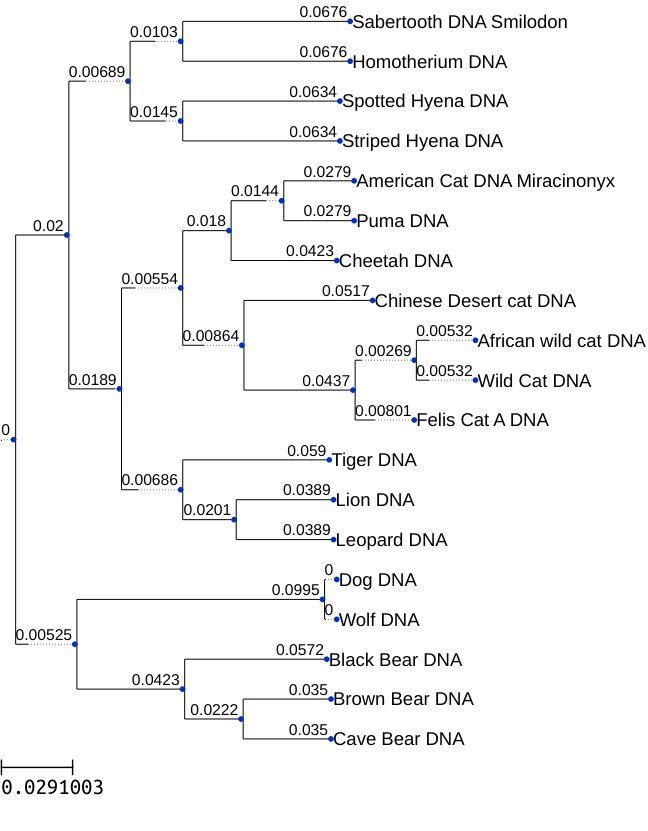

In [21]:
tree_fasta = upgma(M1, list(fasta.keys()))
print(tree_fasta)
t = Tree(tree_fasta)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

((((Sabertooth DNA Smilodon:0.08278809960280561,((((American Cat DNA Miracinonyx:0.033604559508632684,Puma DNA:0.033604559508632684):0.01356001658994968,Cheetah DNA:0.047164576098582364):0.016684399282430804,(Chinese Desert cat DNA:0.05557227842052118,((African wild cat DNA:0.0053192381219836545,Wild Cat DNA:0.0053192381219836545):0.0026892618316515897,Felis Cat A DNA:0.008008499953635244):0.04756377846688594):0.008276696960491985):0.010288298229520917,(Tiger DNA:0.05903300634370695,(Lion DNA:0.03892379763061633,Leopard DNA:0.03892379763061633):0.020109208713090618):0.015104267266827134):0.00865082599227153):0.011503331056240143,(Spotted Hyena DNA:0.06731573078150245,Striped Hyena DNA:0.06731573078150245):0.026975699877543308):0.020625672245585536,Homotherium DNA:0.1149171029046313):0.014580066468449185,((Dog DNA:0.0,Wolf DNA:0.0):0.1128050782157542,(Black Bear DNA:0.06948228399639578,(Brown Bear DNA:0.03503775249228635,Cave Bear DNA:0.03503775249228635):0.03444453150410943):0.04332279

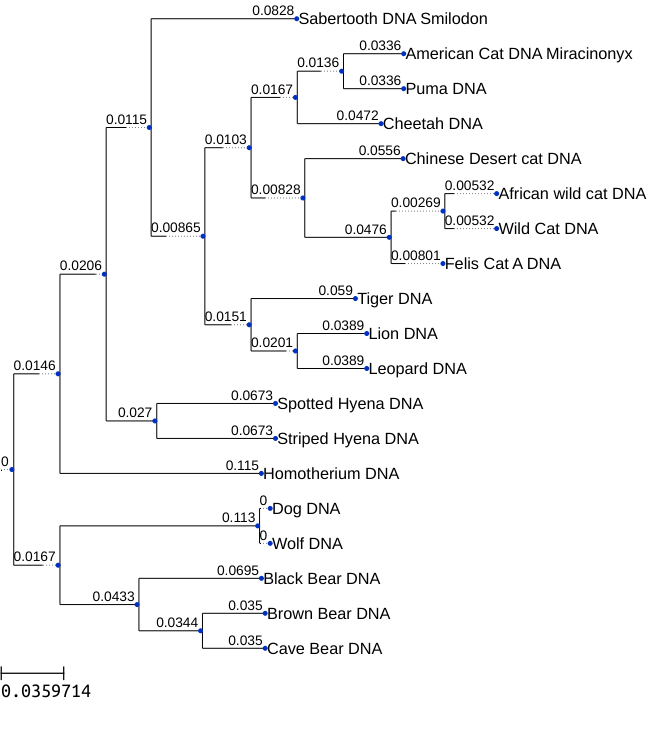

In [26]:
tree_fasta_align = upgma(M2, list(fasta_align.keys()))
print(tree_fasta_align)
t = Tree(tree_fasta_align)
ts = TreeStyle()
ts.show_branch_length = True
t.render('%%inline', w=183, units='mm', tree_style=ts)

On remarque que les 2 m√©thodes de calcul des matrices de distance M1 et M2 donnent des r√©sultats quasiment √©quivalents √† quelques diff√©rences pr√®s.

**Exercice 9 :** Quelles sont les hypoth√®ses faites par UPGMA ? Semblent-elles respect√©es dans le cas pr√©sent ?

R√©ponse : L'hypoth√®se de l'horloge mol√©culaire, c'est-√†-dire que les mutations g√©n√©tiques s'accumulent de mani√®re constante au cours du temps. Ici, cette hypoth√®se semble respect√©e car l'arbre phylog√©n√©tique final semble bien se calquer √† la r√©alit√© (au r√©sultat suppos√©ment attendu).

----
## Enracinement de l'arbre

Apr√®s avoir utilis√© UPGMA pour r√©aliser votre arbre, l'enracinement s'est normalement fait au poids moyen. 

**Exercice 10 :** Quelle autre m√©thode est-il possible d'utiliser pour enraciner un arbre ? Pouvez-vous l'utilisez ici ? Si oui, afficher le nouvel arbre.

R√©ponse : 

In [23]:
# √Ä remplir

----
## Neighbor-joining

Le neighbor-joining est un autre algorithme permettant de calculer un arbre phylog√©nique √† partir d'une matrice de distance. Il a l'avantage de faire moins d'hypoth√®se qu'UPGMA sur les donn√©es (elles ne sont plus forc√©ment ultram√©trique) et il donne donc de meilleurs arbres dans presque tout les cas. Vous trouverez un example d'application de cet algorithme [ici](http://www.evolution-textbook.org/content/free/tables/Ch_27/T11_EVOW_Ch27.pdf).

**Exercice 11 :** Impl√©menter l'algorithme du neighbor-joining, appliquer-le aux donn√©es puis enraciner l'arbre.

In [24]:
# √Ä remplir

----
## Bootstrap

Le bootstrap est une m√©thode permettant de calculer la robustesse des branches d'un arbre. Il sagit de recr√©er un jeu de donn√©es artificiel en tirant n positions dans l'alignement des s√©quences avec remise, n √©tant la longueur de l'alignement. On recr√©er un arbre √† partir de ces nouvelles donn√©es puis on le compare avec l'arbre obtenu avec les donn√©es r√©elles. Si une branche de l'arbre r√©elle est pr√©sente dans l'arbre artificiel, son bootstrap augmente de 1. On r√©p√®tera la proc√©dure 100 fois afin d'avoir un score sur 100 pour chaque branche.

**Exercice 12 :** Calculer le bootstrap des branches des arbres obtenus avec UPGMA et neighbor-joining.

In [25]:
# √Ä remplir

----
## Conclusion

**Exercice 13 :** Quelles sont vos conclusions par rapport √† l'arbre phylog√©nique de *smilodon*, *homotherium* et _M. trumani_ ? Comparer les deux m√©thodes. Comment expliquer les caract√©ristiques morphologiques similaires entre ces trois esp√®ces ? Une r√©ponse d√©taill√©e est attendue.

R√©ponse :